In [1]:
import os
import sys  
sys.path.insert(0, r'C:\Users\aishw\PycharmProjects\FaceRecognition')
import pickle
import numpy as np
from sklearn.preprocessing import Normalizer
from tensorflow.keras.models import load_model
import seaborn as sns
import mtcnn
from architecture import *
import cv2
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from sklearn import metrics
import random
import pandas as pd

In [2]:
face_data = 'train_img'
required_shape = (160, 160)
face_encoder = InceptionResNetV2()
encoder_weights_path = 'facenet_keras_weights.h5'
print('Initializing Face Detector Object...')
face_detector = mtcnn.MTCNN()
print('Face Detector Object Initialized.')
print('Loading Weights into FaceNet...')
face_encoder.load_weights(encoder_weights_path)
print('Weights Loaded into FaceNet.')

Initializing Face Detector Object...
Face Detector Object Initialized.
Loading Weights into FaceNet...
Weights Loaded into FaceNet.


In [4]:
encodes = []
encoding_dict = dict()
l2_normalizer = Normalizer('l2')

In [5]:
def normalize(img):
    mean, std = img.mean(), img.std()
    return (img - mean) / std

In [6]:
extracted_face = 'face_extracted_mtcnn'
if not os.path.exists(extracted_face):
    os.mkdir(extracted_face)
for faces_names in os.listdir(face_data):
    if not os.path.exists(os.path.join(extracted_face, faces_names)):
        os.mkdir(os.path.join(extracted_face, faces_names))

In [7]:
for face_names in os.listdir(face_data):
    person_dir = os.path.join(face_data, face_names)
    i = 0
    for image_name in os.listdir(person_dir):
        image_path = os.path.join(person_dir, image_name)
        img_BGR = cv2.imread(image_path)
        img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
        x = face_detector.detect_faces(img_RGB)
        if len(x) > 0:
            for rect in x:
                x1, y1, width, height = rect['box']
                x1, y1 = abs(x1), abs(y1)
                x2, y2 = x1 + width, y1 + height
                face = img_RGB[y1: y2, x1: x2]
                cv2.imwrite(os.path.join(os.path.join(extracted_face, face_names), str(i) + '.jpg'), face)
                i += 1

In [8]:
confidence_t = 0.99
recognition_t = 0.35

In [9]:
def get_face(img, box):
    x1, y1, width, height = box
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = img[y1:y2, x1:x2]
    return face, (x1, y1), (x2, y2)

In [10]:
def get_encode(face_encoder, face, size):
    face = normalize(face)
    face = cv2.resize(face, size)
    encode = face_encoder.predict(np.expand_dims(face, axis=0))[0]
    return encode

In [11]:
def load_pickle(path):
    with open(path, 'rb') as f:
        encoding_dict = pickle.load(f)
    return encoding_dict

In [12]:
def detect(img, face_detector, face_encoder, encoding_dict):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_detector.detect_faces(img_rgb)
    name = 'unknown'
    for res in results:
        if res['confidence'] < confidence_t:
            continue
        face, pt_1, pt_2 = get_face(img_rgb, res['box'])
        encode = get_encode(face_encoder, face, required_shape)
        encode = l2_normalizer.transform(encode.reshape(1, -1))[0]
        name = 'unknown'

        distance = float("inf")
        for db_name, db_encode in encoding_dict.items():
            dist = cosine(db_encode, encode)
            if dist < recognition_t and dist < distance:
                name = db_name
                distance = dist

        if name == 'unknown':
            cv2.rectangle(img, pt_1, pt_2, (0, 0, 255), 2)
            cv2.putText(img, name, pt_1, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
        else:
            cv2.rectangle(img, pt_1, pt_2, (0, 255, 0), 2)
            cv2.putText(img, name + ' ' + str(round(distance, 2)), (pt_1[0], pt_1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 200, 200), 2)
            #cv2.putText(img, name, (pt_1[0], pt_1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    return img, name

In [13]:
def identify_Using_FaceNet():
    encodings_path = 'encoding/encodings_MTCNN.pkl'
    encoding_dict = load_pickle(encodings_path)
    frame = cv2.imread('test_img/Ankita Mandal/Capture4.jpeg')
    frame, names = detect(frame, face_detector, face_encoder, encoding_dict)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    print(names)
    plt.imshow(frame)
    plt.show()

Ankita Mandal


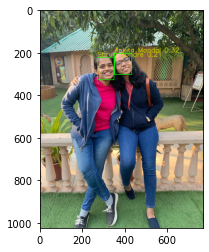

In [15]:
identify_Using_FaceNet()

In [ ]:
def pred_vs_actual_training_data():
    y_actual = []
    y_pred = []
    encodings_path = 'encoding/encodings_MTCNN.pkl'
    encoding_dict = load_pickle(encodings_path)
    for face_names in random.sample(os.listdir(face_data), len(os.listdir(face_data))):
        person_dir = os.path.join(face_data, face_names)
        for image_name in os.listdir(person_dir):
            image_path = os.path.join(person_dir, image_name)
            frame = cv2.imread(image_path)
            _, names = detect(frame, face_detector, face_encoder, encoding_dict)
            y_actual.append(str(face_names))
            y_pred.append(names)
    return y_actual, y_pred

In [ ]:
y_actual, y_pred = pred_vs_actual_training_data()

In [ ]:
print(metrics.confusion_matrix(y_actual, y_pred, labels=os.listdir(face_data)))

In [ ]:
print(metrics.classification_report(y_actual, y_pred, labels=os.listdir(face_data)))

In [ ]:
df_cm = pd.DataFrame(metrics.confusion_matrix(y_actual, y_pred, labels=os.listdir(face_data)), index = os.listdir(face_data), columns = os.listdir(face_data))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [ ]:
test_dir = 'test_img'
output_dir = 'output_dir'
encodings_path = 'encoding/encodings_MTCNN.pkl'
encoding_dict = load_pickle(encodings_path)
for face_names in os.listdir(test_dir):
        person_dir = os.path.join(test_dir, face_names)
        person_output = os.path.join(output_dir, face_names)
        for image_name in os.listdir(person_dir):
            frame = cv2.imread(os.path.join(person_dir, image_name))
            frame, names = detect(frame, face_detector, face_encoder, encoding_dict)
            if (image_name[-4:] == 'jpeg'):
                image_name = image_name[0:-5] + '_mtcnn.jpg'
            else:
                image_name = image_name[0:-4] + '_mtcnn.jpg'
            cv2.imwrite(os.path.join(person_output, image_name), frame)

In [14]:
if not os.path.exists(r'C:\Users\aishw\PycharmProjects\FaceRecognition\all_test'):
    os.mkdir(r'C:\Users\aishw\PycharmProjects\FaceRecognition\all_test')
file_x_path = r'C:\Users\aishw\PycharmProjects\FaceRecognition'
test_place = 'test_img'
put_in = r'C:\Users\aishw\PycharmProjects\FaceRecognition\all_test'
d = 1
test = os.path.join(file_x_path, test_place)
for faces in os.listdir(test):
    person_dir = os.path.join(test, faces)
    for image in os.listdir(person_dir):
        frame = cv2.imread(os.path.join(person_dir, image))
        image_name = str(d) + '.jpg'
        cv2.imwrite(os.path.join(put_in, image_name), frame)
        d += 1

In [15]:
output_test = r'C:\Users\aishw\PycharmProjects\FaceRecognition\output_test'
if not os.path.exists(output_test):
    os.mkdir(output_test)
encodings_path = 'encoding/encodings_MTCNN.pkl'
encoding_dict = load_pickle(encodings_path)
for image_name in os.listdir(put_in):
    frame = cv2.imread(os.path.join(put_in, image_name))
    frame, names = detect(frame, face_detector, face_encoder, encoding_dict)
    image_name = image_name[0:-4] + '_mtcnn.jpg'
    cv2.imwrite(os.path.join(output_test, image_name), frame)

In [38]:
col_list = ["Photograph", "True Face", "Detected Face", "Detected Face HOG"]
df = pd.read_csv(r'C:\Users\aishw\PycharmProjects\FaceRecognition\outputs2.csv', usecols=col_list)
y_pred = df['Detected Face'].to_numpy()
y_pred_hog = df['Detected Face HOG'].to_numpy()
y_actual = df['True Face'].to_numpy()
print(y_pred)
print(y_actual)
print(y_pred_hog)
labels = ['Aishwarya Patange', 'Ajita Patange', 'Akshay Ghaisas', 'Amul Patange', 'Aneesh Pol', 'Anjali Patil', 'Ankita Mandal', 'Anoushka Thakker', 'Apoorva Sudheesh', 'Arya Kasulla', 'Aryan Patange', 'Atique Kudchi', 'Dhananjay Teli', 'Disha Mhatre', 'Harshal Marathe', 'Isha Naik', 'Kunal Khaladkar', 'Lavanya Soparkar', 'Mihir Sabnis', 'Nrupaja Vartak', 'Rucha Naik', 'Sakshi Modi', 'Shelly Singh', 'Shruti Bondre', 'Unknown', 'not detected']
print(labels)

['Unknown' 'Unknown' 'Unknown' 'Aishwarya Patange' 'Amul Patange'
 'Ajita Patange' 'Aishwarya Patange' 'Akshay Ghaisas' 'Unknown' 'Unknown'
 'Unknown' 'Akshay Ghaisas' 'Aishwarya Patange' 'Aneesh Pol' 'Aneesh Pol'
 'Unknown' 'Aneesh Pol' 'Unknown' 'Aneesh Pol' 'Unknown' 'Anjali Patil'
 'Unknown' 'Unknown' 'Anjali Patil' 'Unknown' 'Unknown' 'Ankita Mandal'
 'Ankita Mandal' 'Unknown' 'Unknown' 'Ankita Mandal' 'Unknown'
 'Sakshi Modi' 'Shruti Bondre' 'Shruti Bondre' 'Ankita Mandal' 'Unknown'
 'Unknown' 'Shruti Bondre' 'Ankita Mandal' 'Unknown' 'Unknown'
 'Anoushka Thakker' 'Anoushka Thakker' 'Anoushka Thakker' 'Unknown'
 'Unknown' 'Arya Kasulla' 'Aryan Patange' 'Unknown' 'Aryan Patange'
 'Aryan Patange' 'Atique Kudchi' 'Apoorva Sudheesh' 'Unknown' 'Unknown'
 'Atique Kudchi' 'Unknown' 'Dhananjay Teli' 'Unknown' 'Unknown' 'Unknown'
 'Dhananjay Teli' 'Disha Mhatre' 'Disha Mhatre' 'Disha Mhatre'
 'Rucha Naik' 'Unknown' 'Unknown' 'Harshal Marathe' 'Harshal Marathe'
 'Kunal Khaladkar' 'Unknown'

In [40]:
print(metrics.confusion_matrix(y_actual, y_pred, labels = labels))
print(metrics.classification_report(y_actual, y_pred, labels = labels))

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
   1  0]
 [ 0

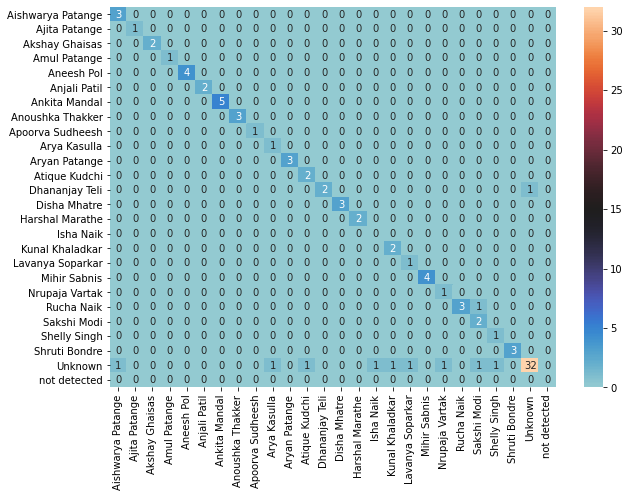

In [41]:
df_cm = pd.DataFrame(metrics.confusion_matrix(y_pred, y_actual, labels = labels), index = labels, columns = labels)
plt.figure(figsize = (10,7))
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
sns.heatmap(df_cm, center = 15, annot=True)

In [39]:
print(metrics.confusion_matrix(y_actual, y_pred_hog, labels = labels))
print(metrics.classification_report(y_actual, y_pred_hog, labels = labels))

[[ 3  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  3]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   1  1]
 [ 0

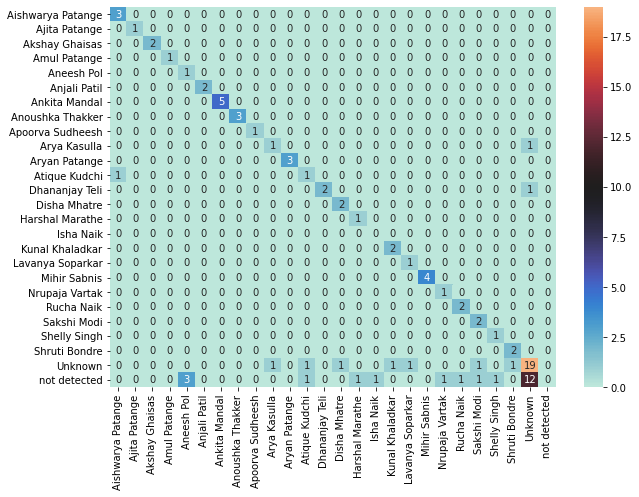

In [43]:
df_cm = pd.DataFrame(metrics.confusion_matrix(y_pred_hog, y_actual, labels = labels), index = labels, columns = labels)
plt.figure(figsize = (10,7))
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
sns.heatmap(df_cm, center = 10, annot=True)